# TODO:

- Median / mean phi2 position
- Don't reflex correct pm_phi1, pm_phi2

In [48]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline
from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

Load the "data":

In [212]:
ana_data = Table.read('../data/track.fits')
ana_data.colnames

['phi1',
 'n',
 'density',
 'w',
 'pm_phi1_cosphi2',
 'pm_phi1_cosphi2_error',
 'pm_phi2',
 'pm_phi2_error']

In [20]:
# Koposov et al. 
kop_pm = ascii.read("""phi1 pm_phi1 pm_phi2 err
-55.00 -13.60 -5.70 1.30
-45.00 -13.10 -3.30 0.70
-35.00 -12.20 -3.10 1.00
-25.00 -12.60 -2.70 1.40
-15.00 -10.80 -2.80 1.00""")

kop_phi2 = ascii.read("""phi1 phi2 err
-60.00 -0.64 0.15
-56.00 -0.89 0.27
-54.00 -0.45 0.15
-48.00 -0.08 0.13
-44.00 0.01 0.14
-40.00 -0.00 0.09
-36.00 0.04 0.10
-34.00 0.06 0.13
-32.00 0.04 0.06
-30.00 0.08 0.10
-28.00 0.03 0.12
-24.00 0.06 0.05
-22.00 0.06 0.13
-18.00 -0.05 0.11
-12.00 -0.29 0.16
-2.00 -0.87 0.07""")

kop_dist = ascii.read("""phi1 dist err
-55.00 7.20 0.30
-45.00 7.59 0.40
-35.00 7.83 0.30
-25.00 8.69 0.40
-15.00 8.91 0.40
0.00 9.86 0.50""")

kop_vr = ascii.read("""phi1 phi2 vr err
-45.23 -0.04 28.8 6.9
-43.17 -0.09 29.3 10.2
-39.54 -0.07 2.9  8.7
-39.25 -0.22 -5.2 6.5
-37.95 0.00 1.1   5.6
-37.96 -0.00 -11.7 11.2
-35.49 -0.05 -50.4 5.2
-35.27 -0.02 -30.9 12.8
-34.92 -0.15 -35.3 7.5
-34.74 -0.08 -30.9 9.2
-33.74 -0.18 -74.3 9.8
-32.90 -0.15 -71.5 9.6
-32.25 -0.17 -71.5 9.2
-29.95 -0.00 -92.7 8.7
-26.61 -0.11 -114.2 7.3
-25.45 -0.14 -67.8 7.1
-24.86 0.01 -111.2 17.8
-21.21 -0.02 -144.4 10.5
-14.47 -0.15 -179.0 10.0
-13.73 -0.28 -191.4 7.5
-13.02 -0.21 -162.9 9.6
-12.68 -0.26 -217.2 10.7
-12.55 -0.23 -172.2 6.6""")

In [213]:
dt = 0.5 * u.Myr
n_steps = 100

_phi2_sigma = 0.2 # deg
_dist_sigma = 0.1 # kpc
_vr_sigma = 1 # km/s

def ln_likelihood(p, phi1_0, data, ham, gc_frame):
    # initial conditions at phi1_0
    phi2, d, pm1, pm2, vr = p
    
    c = gc.GD1(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
               pm_phi1_cosphi2=pm1*u.mas/u.yr,
               pm_phi2=pm2*u.mas/u.yr,
               radial_velocity=vr*u.km/u.s)
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    
    orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)
    model_gd1 = orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
    
    model_x = model_gd1.phi1.wrap_at(180*u.deg).degree
    if model_x[-1] < -180:
        return -np.inf
    
    model_phi2 = model_gd1.phi2.degree
    model_dist = model_gd1.distance.to(u.kpc).value
    model_pm1 = model_gd1.pm_phi1_cosphi2.to(u.mas/u.yr).value
    model_pm2 = model_gd1.pm_phi2.to(u.mas/u.yr).value
    model_vr = model_gd1.radial_velocity.to(u.km/u.s).value
    
    # plt.errorbar(data['phi2'][0], data['phi2'][1], marker='o', linestyle='none')
#     plt.errorbar(data['pm2'][0], data['pm2'][1], marker='o', linestyle='none')
#     plt.plot(model_x, model_pm2)
#     return
    
    ix = np.argsort(model_x)
    model_x = model_x[ix]
    
    # define interpolating functions
    order = 3
    bbox = [-180, 180]
    
    chi2 = 0
    
    phi2_interp = InterpolatedUnivariateSpline(model_x, model_phi2[ix], 
                                               k=order, bbox=bbox)
    dist_interp = InterpolatedUnivariateSpline(model_x, model_dist[ix], 
                                               k=order, bbox=bbox)
    pm1_interp = InterpolatedUnivariateSpline(model_x, model_pm1[ix], 
                                              k=order, bbox=bbox)
    pm2_interp = InterpolatedUnivariateSpline(model_x, model_pm2[ix], 
                                              k=order, bbox=bbox)
    vr_interp = InterpolatedUnivariateSpline(model_x, model_vr[ix], 
                                             k=order, bbox=bbox)
    
    phi2_sigma = np.sqrt(_phi2_sigma**2 + data['phi2'][2]**2)
    chi2 += np.sum(-(phi2_interp(data['phi2'][0]) - data['phi2'][1])**2 / phi2_sigma**2 - 2*np.log(phi2_sigma))
    
    dist_sigma = np.sqrt(_dist_sigma**2 + data['dist'][2]**2)
    chi2 += np.sum(-(dist_interp(data['dist'][0]) - data['dist'][1])**2 / dist_sigma**2 - 2*np.log(dist_sigma))
    
    pm1_sigma = data['pm1'][2]
    chi2 += np.sum(-(pm1_interp(data['pm1'][0]) - data['pm1'][1])**2 / pm1_sigma**2 - 2*np.log(pm1_sigma))
    
    pm2_sigma = data['pm2'][2]
    chi2 += np.sum(-(pm2_interp(data['pm2'][0]) - data['pm2'][1])**2 / pm2_sigma**2 - 2*np.log(pm2_sigma))
    
    vr_sigma = np.sqrt(data['vr'][2]**2 + _vr_sigma**2)
    chi2 += np.sum(-(vr_interp(data['vr'][0]) - data['vr'][1])**2 / vr_sigma**2 - 2*np.log(vr_sigma))

    return chi2

In [214]:
ana_data.colnames

['phi1',
 'n',
 'density',
 'w',
 'pm_phi1_cosphi2',
 'pm_phi1_cosphi2_error',
 'pm_phi2',
 'pm_phi2_error']

In [215]:
data = dict()

# Koposov data:
# data['phi2'] = (kop_phi2['phi1'], kop_phi2['phi2'], kop_phi2['err'])
# data['dist'] = (kop_dist['phi1'], kop_dist['dist'], kop_dist['err'])
# data['pm1'] = (kop_pm['phi1'], kop_pm['pm_phi1'], kop_pm['err'])
# data['pm2'] = (kop_pm['phi1'], kop_pm['pm_phi2'], kop_pm['err'])
# data['vr'] = (kop_vr['phi1'], kop_vr['vr'], kop_vr['err'])

# TODO: phi2 from stream track?
data['phi2'] = (kop_phi2['phi1'], kop_phi2['phi2'], kop_phi2['err'])
data['dist'] = (kop_dist['phi1'], kop_dist['dist'], kop_dist['err'])
data['pm1'] = (ana_data['phi1'], ana_data['pm_phi1_cosphi2'], ana_data['pm_phi1_cosphi2_error'])
data['pm2'] = (ana_data['phi1'], ana_data['pm_phi2'], ana_data['pm_phi2_error'])
data['vr'] = (kop_vr['phi1'], kop_vr['vr'], kop_vr['err'])

In [216]:
ham = gp.Hamiltonian(gp.LogarithmicPotential(v_c=225*u.km/u.s, r_h=0*u.kpc, q1=1, q2=1, q3=0.89, units=galactic))

In [217]:
gc_frame = coord.Galactocentric(z_sun=0*u.pc)
phi1_0 = 20. * u.deg

p0 = (-3., 12., -5.5, -1.5, -340.)

In [218]:
from scipy.optimize import minimize

In [219]:
res = minimize(lambda *x: -ln_likelihood(*x), x0=p0, args=(phi1_0, data, ham, coord.Galactocentric()))

In [220]:
res

      fun: 1559.9290289217506
 hess_inv: array([[ 2.72845910e-06,  2.73150580e-06,  2.23184752e-06,
        -6.94239819e-07, -2.50897140e-06],
       [ 2.73150580e-06,  2.75163273e-06,  2.21330522e-06,
        -6.85189953e-07, -2.53730131e-06],
       [ 2.23184752e-06,  2.21330522e-06,  1.85306530e-06,
        -5.81058558e-07, -2.02130734e-06],
       [-6.94239819e-07, -6.85189953e-07, -5.81058558e-07,
         1.83094207e-07,  6.23835984e-07],
       [-2.50897140e-06, -2.53730131e-06, -2.02130733e-06,
         6.23835984e-07,  2.34625526e-06]])
      jac: array([ -66.57037354,   22.68257141,  -43.90509033, -210.27630615,
        -21.23664856])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 870
      nit: 30
     njev: 123
   status: 2
  success: False
        x: array([  -4.63323668,   16.3393089 ,   -4.30769644,   -1.14693098,
       -263.99664731])

In [221]:
res.x

array([  -4.63323668,   16.3393089 ,   -4.30769644,   -1.14693098,
       -263.99664731])

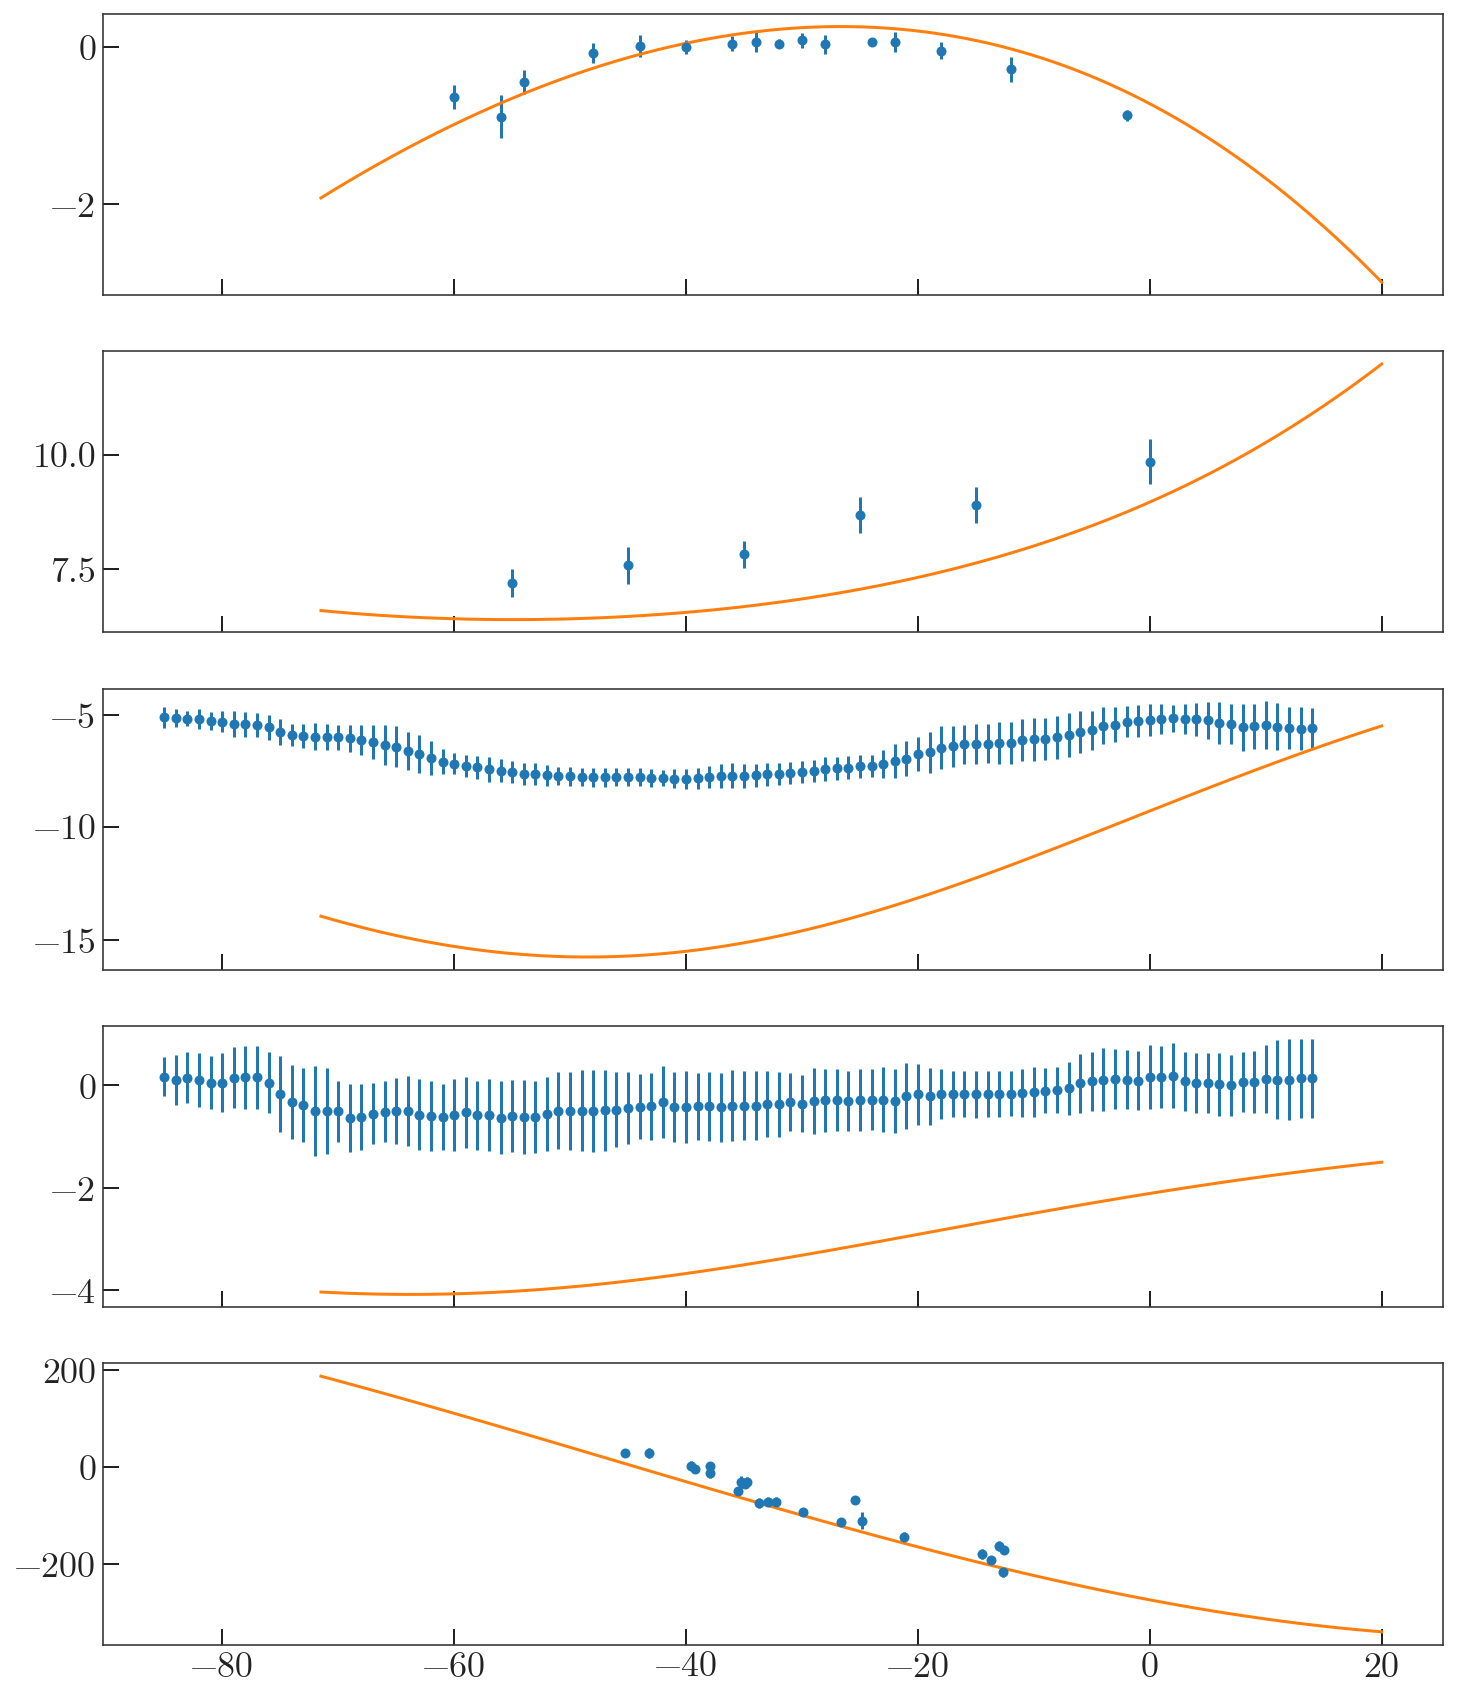

In [223]:
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

axes[0].errorbar(data['phi2'][0], data['phi2'][1], data['phi2'][2], marker='o', linestyle='none')
axes[1].errorbar(data['dist'][0], data['dist'][1], data['dist'][2], marker='o', linestyle='none')
axes[2].errorbar(data['pm1'][0], data['pm1'][1], data['pm1'][2], marker='o', linestyle='none')
axes[3].errorbar(data['pm2'][0], data['pm2'][1], data['pm2'][2], marker='o', linestyle='none')
axes[4].errorbar(data['vr'][0], data['vr'][1], data['vr'][2], marker='o', linestyle='none')

# phi2, d, pm1, pm2, vr = res.x
phi2, d, pm1, pm2, vr = p0

c = gc.GD1(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
           pm_phi1_cosphi2=pm1*u.mas/u.yr,
           pm_phi2=pm2*u.mas/u.yr,
           radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)
model_gd1 = orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

model_x = model_gd1.phi1.wrap_at(180*u.deg).degree

axes[0].plot(model_x, model_gd1.phi2.degree, marker='')
axes[1].plot(model_x, model_gd1.distance, marker='')
axes[2].plot(model_x, model_gd1.pm_phi1_cosphi2.to(u.mas/u.yr).value, marker='')
axes[3].plot(model_x, model_gd1.pm_phi2.to(u.mas/u.yr).value, marker='')
axes[4].plot(model_x, model_gd1.radial_velocity.to(u.km/u.s).value, marker='')